In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
from adjustText import adjust_text
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the `.h5` file
# use gene symbols for the variable names (variables-axis index)
output_data_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp/Figs"
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/chimp"
gene_screenfile="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/chimp/Chimp_chrXYMT_gene.txt"
rm_genelist = pd.read_csv(gene_screenfile,index_col=False,sep="\t",header=0)
sc.settings.figdir = output_fig_dir

In [ ]:
#read in exc cells
sub_adata = sc.read(os.path.join(input_dir,"exc_subclass.h5ad"))
print(sub_adata)

sub_smplist = sub_adata.obs_names.tolist()

raw_adata = sc.read(os.path.join(input_dir,"chimp_all_raw_filt.h5ad"))
print(raw_adata)
adata = raw_adata[raw_adata.obs_names.isin(sub_smplist),:]
print(adata)

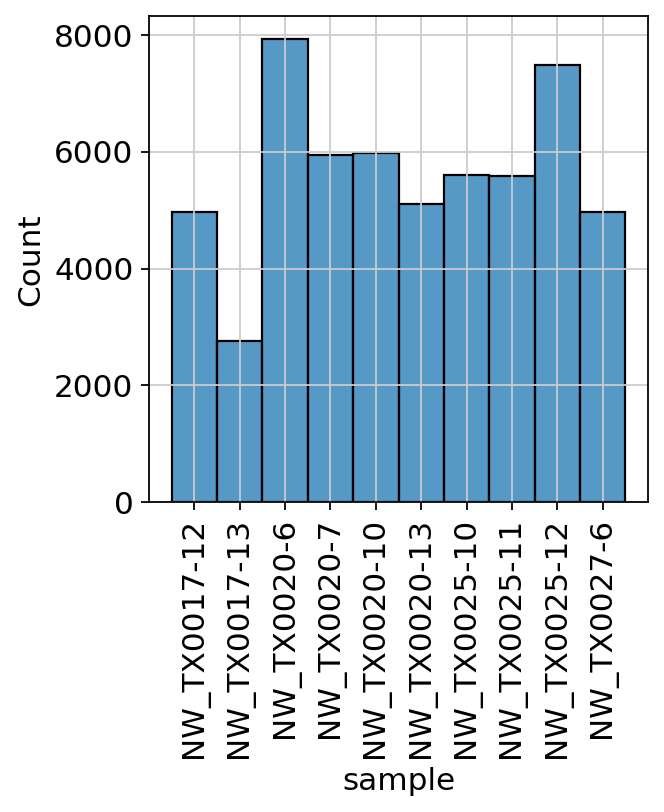

In [ ]:
#print(sub_adata.obs['sample'].value_counts())
#fig, axs = plt.subplots(1,1,figsize=(5,10))
plot = sns.histplot(adata.obs["sample"], kde=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"exc_sample_dist.png"),bbox_inches="tight")

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


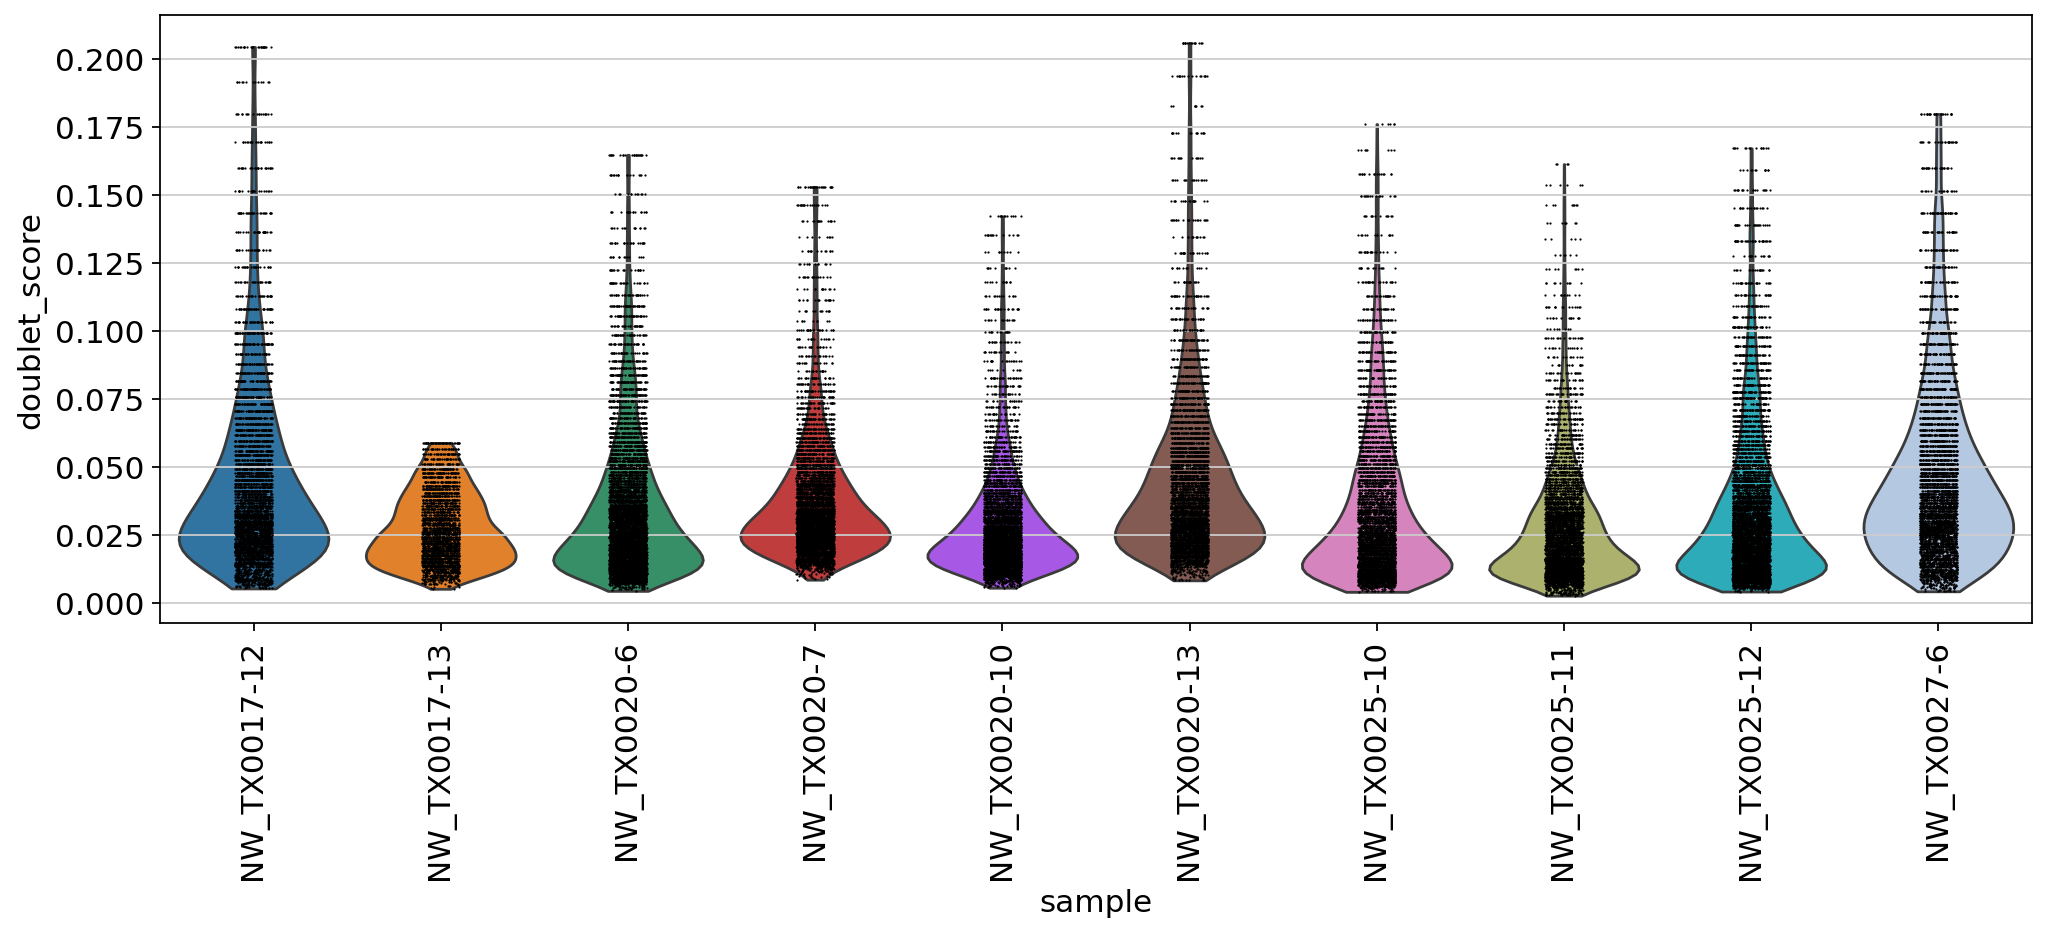

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="doublet_score", groupby="sample", ax=axs, show=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"exc_doublet_score.png"),bbox_inches="tight")

In [ ]:
# calculate percent ribosomal genes
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
## the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
#adata.obs['percent_ribo'] = np.sum(
#    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

False    20176
True        13
Name: mt, dtype: int64


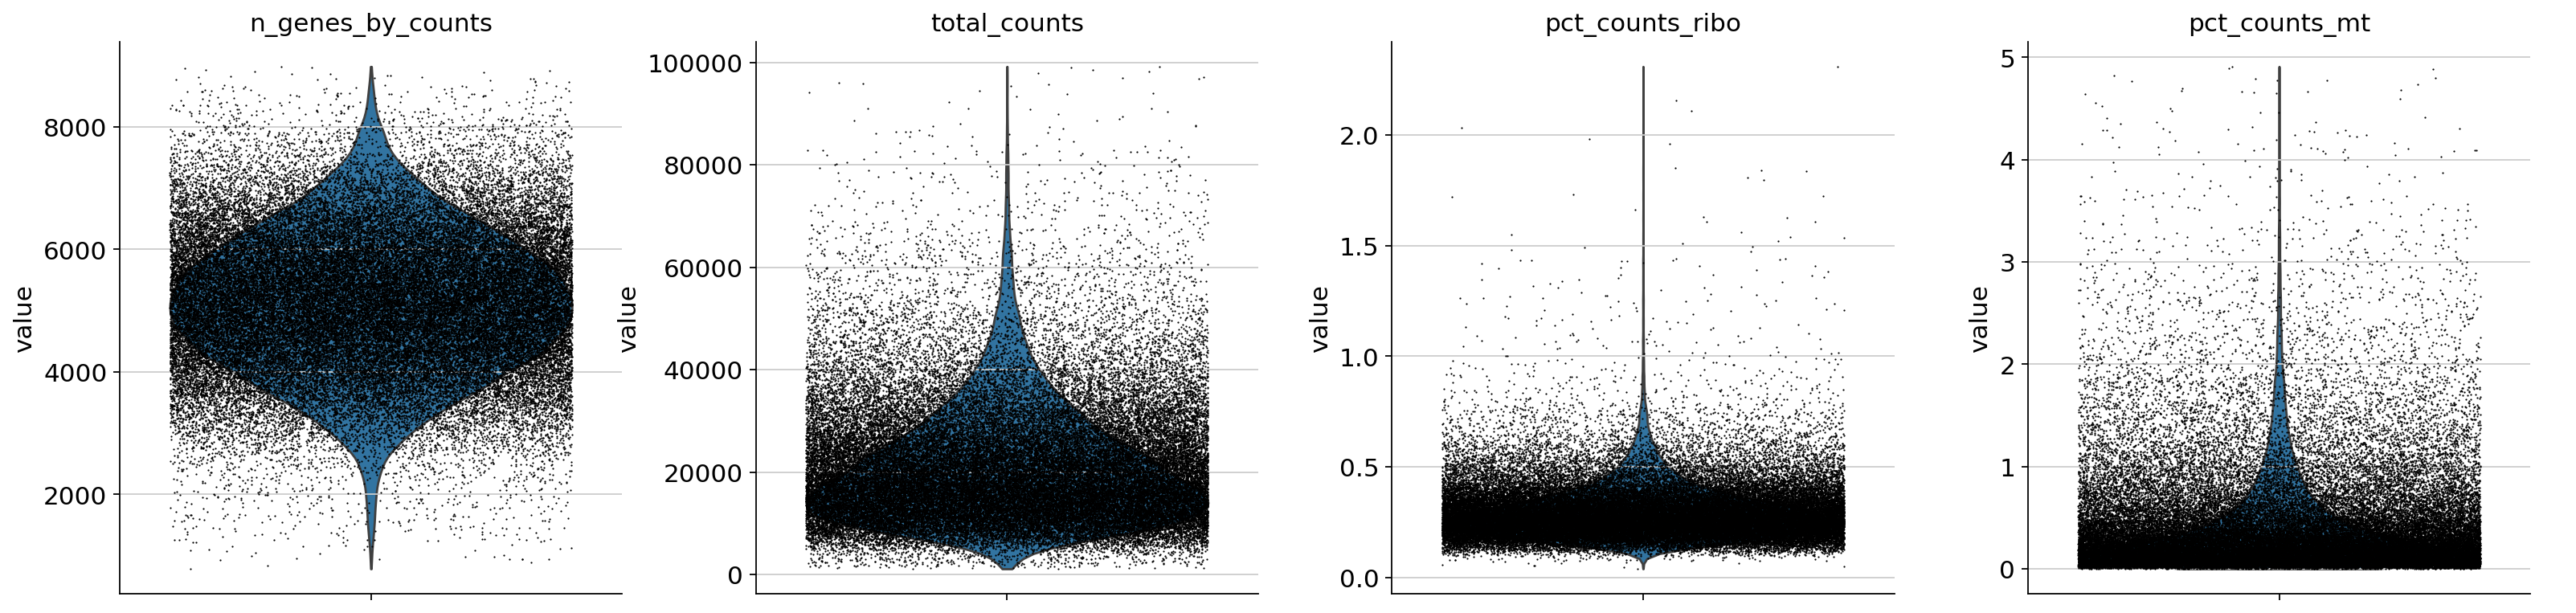

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
print(adata.var['mt'].value_counts())
adata.obs['pct_counts_mt'] = raw_adata[raw_adata.obs_names.isin(sub_smplist),:].obs['pct_counts_mt']
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo','pct_counts_mt'],jitter=0.4, multi_panel=True, show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_mt_ribo_qc.png"))
#plt.show()

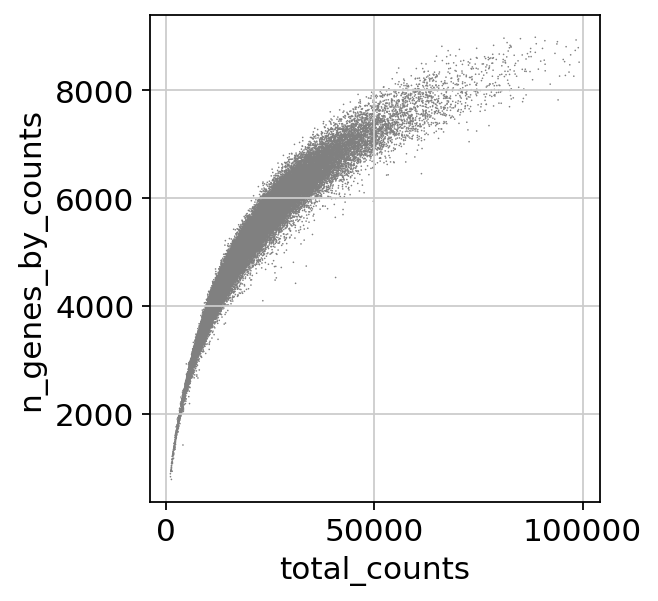

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_genes_by_counts.png"))
#Can color plot based on any variable from obs

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


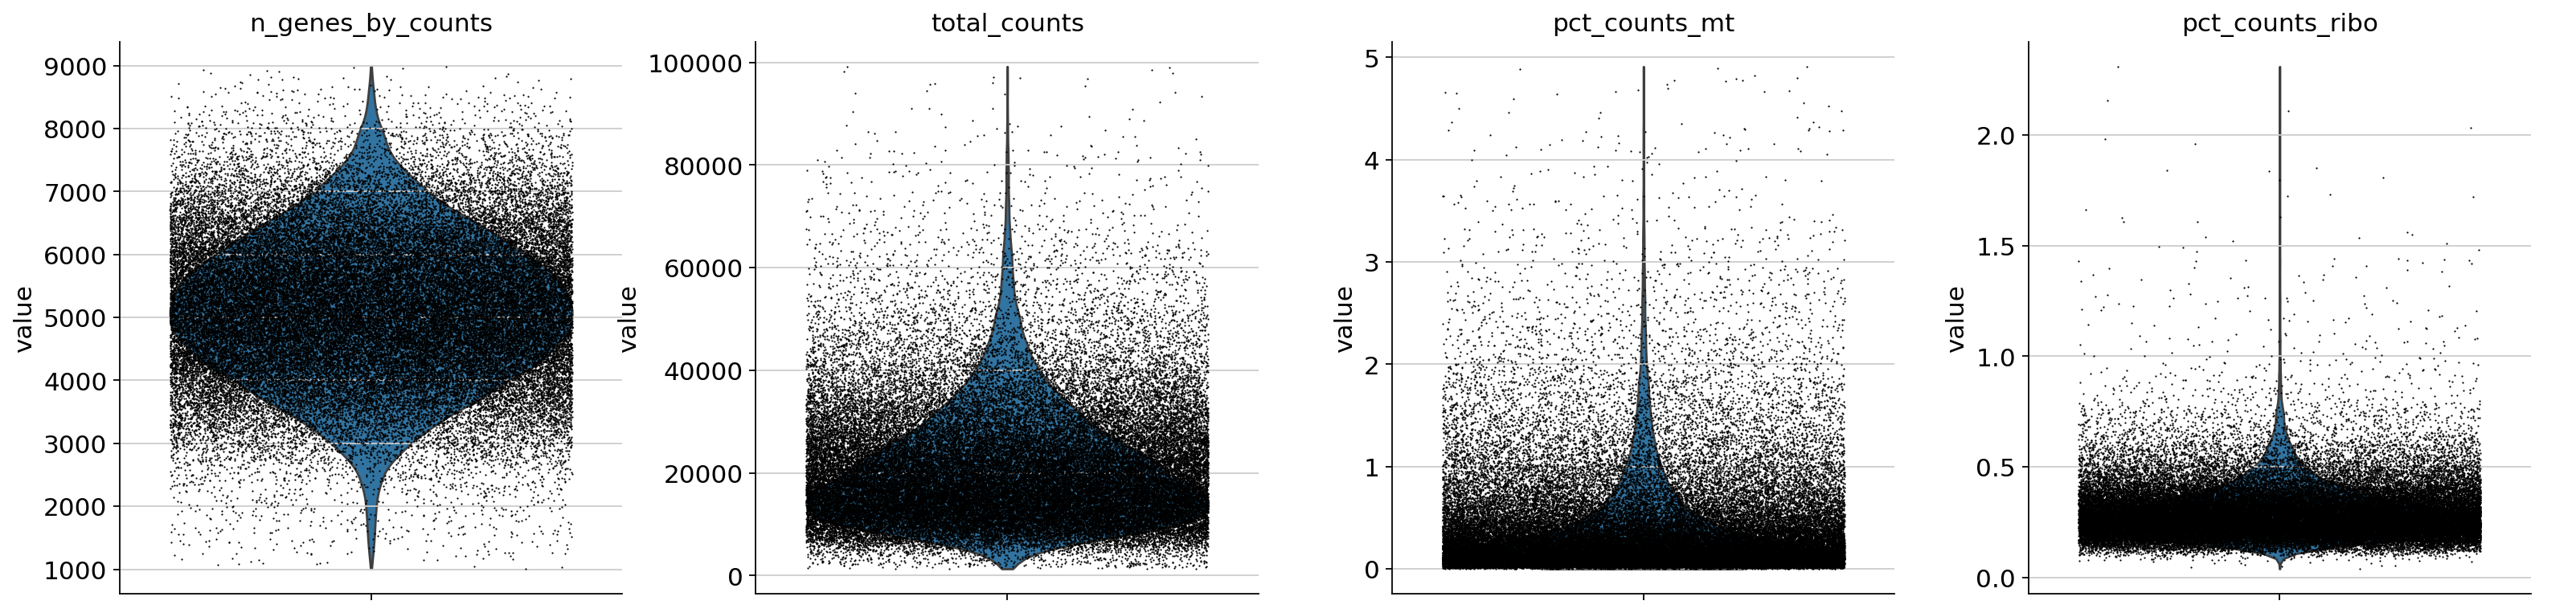

In [ ]:
#filter cells by number of genes per cell
adata = adata[adata.obs.n_genes_by_counts > 1000, :]
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
#mitocondrial genes were removed in the processed adata, add it back from the raw_adata the percent counts mt to the adata of the specific cell class adata
adata.obs['pct_counts_mt'] = raw_adata[raw_adata.obs_names.isin(sub_smplist),:].obs['pct_counts_mt']
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],jitter=0.4, multi_panel=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_filtering_genes_qc.png"))
#save a copy of adata after every major change

In [ ]:
#sc.pp.filter_cells(adata, max_counts=40000)
sc.pp.filter_genes(adata, min_cells=3)


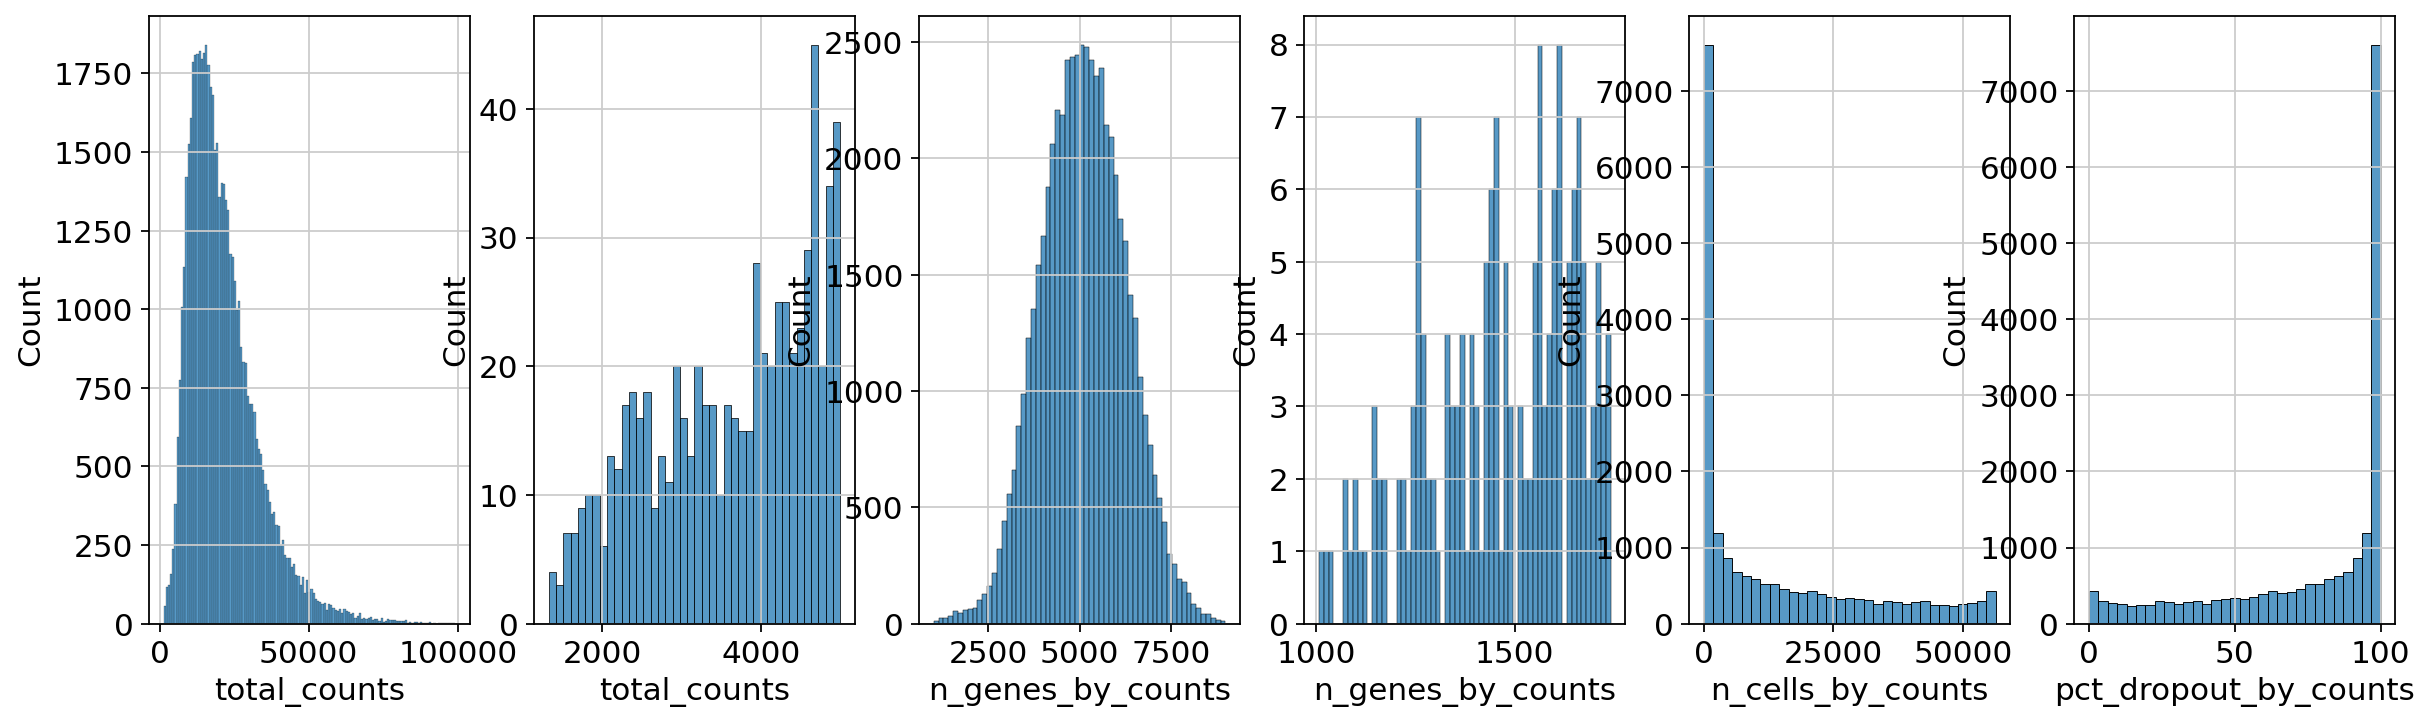

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 5000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1750], kde=False, bins=60, ax=axs[3])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[4])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[5])
plt.savefig(os.path.join(output_fig_dir,"after_filtering_exc_counts_dist.png"))

In [ ]:
#normalization
#normalize to 10000 reads, log transformed,
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.025, max_mean=3, min_disp=0.5, flavor="seurat", batch_key='sample')
sc.pl.highly_variable_genes(adata,show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_highly_variable_genes.png"))
print(len(adata.var_names[adata.var.highly_variable]))

In [ ]:
#save normalized adata
adata.raw = adata

In [ ]:
#ribosomal genes in highly variable genes
hvg_gene = adata.var_names[adata.var.highly_variable]
print(hvg_gene[hvg_gene.str.startswith('RPL')])
print(hvg_gene[hvg_gene.str.startswith('RPS')])

In [ ]:
hvg_df = pd.DataFrame()
hvg_df['gene'] = adata.var_names
hvg_df['hvg'] = adata.var.highly_variable.tolist()
hvg_df.to_csv(os.path.join(output_data_dir,"exc_hvg.txt"),index=False,sep="\t")

In [ ]:
#The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed, and ribosomal gene expressed. Scale the data to unit variance.
adata = adata[:, adata.var.highly_variable]


In [ ]:
print(adata)
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt','pct_counts_ribo'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [ ]:
#remove mt genes, and sex genes before clustering
filt_gene = adata.var_names[~adata.var.gene_ids.isin(rm_genelist['gene'])]
adata = adata[:,filt_gene]

computing PCA
    on highly variable genes
    with n_comps=50


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


    finished (0:00:12)


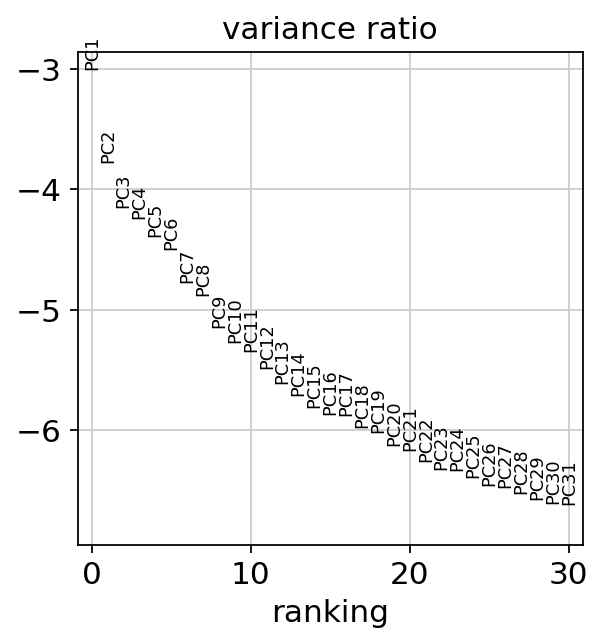

In [ ]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_pca_var_ratio.png"))

In [ ]:
#batch correction
sc.external.pp.harmony_integrate(adata, 'species')
#replcae PCA by the batch corrected data
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)


In [ ]:
sc.tl.leiden(adata, resolution=1.5)
print(adata.obs.leiden.value_counts())

In [ ]:
sc.pl.umap(adata, color=["sample","leiden"], cmap="tab20",show=False,wspace=0.5)
plt.savefig(os.path.join(output_fig_dir,"exc_Harmony_umap_by_sample_level2.png"))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
#Get the most variable genes that define each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False,show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_level2_rank_genes_groups.png"))

In [ ]:
#calculate paga & plot
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False,show =False,use_raw=True)  # remove `plot=False` if you want to see the coarse-grained graph
#plt.savefig(os.path.join(output_dir,"paga_leiden_cluster.png"))
#show which genes are active in which clusters for the three overall clusters (umap)
sc.tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.leiden(adata, resolution=3.5)
print(adata.obs.leiden.value_counts())

In [ ]:
#Get the most variable genes that define each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False,show=False)
plt.savefig(os.path.join(output_fig_dir,"exc_level2_rank_genes_groups.png"))

In [ ]:
#sc.pl.umap(adata, color=["leiden"], cmap="tab20",show=False,wspace=0.5, legend_loc = "on data")
#plt.savefig(os.path.join(output_fig_dir,"exc_Harmony_umap_by_level2.png"))
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300), "font.size": (5), "font.weight": ("normal"), "text.color": ("gold")}):
    sc.pl.umap(adata, color=["leiden"], cmap="tab20",show=False, wspace = 0.5, legend_loc = "on data")
    plt.savefig(os.path.join(output_fig_dir,"exc_Harmony_umap_by_level2.png"))

In [ ]:
L2_3_IT = ["CUX2","TAFA1"] #Intratelencephalic projecting
L5_ET = ["FEZF2"] #LOC105376457, OR51E2 marker of extratelencephalic
L5_IT = ["RORB","POU6F2"] # LOC105374971 and CUX2 and TAFA1 and no HS3ST2
L5_6NP = ["PHLDB2", "TLL1"] # NPSR1_AS1 near projecting
L6_CT = ["SEMA5A"] #EGFEM1P
L6_IT_Car3 =["ATP10A","RGS12"] # RGS12 KLHL1
L6_IT =["THEMIS","PDE7B","RGS20"] #LINC00343, LOC101928278 RGS20
L6b = ["MDFIC","NPFFR2"]
#L5 marker RORB
marker_genes = L2_3_IT + L5_ET + L5_IT + L5_6NP + L6_CT + L6_IT_Car3 + L6_IT + L6b

#IT cells
L5_6NP = ["33","47"]
L6_IT_Car3 = ["32","34"] #PDE7B and ATP10A
L6b = ["15","43"] #NPFFR2 and SEMA5A
L6_CT = ["0","7","10"]
#L6_CT = ["31","41"] # SEMA3E
L5_IT = ["5","6","16","30","38","40","42"]
L5_NP = ["13","21"] # add PHLDB2 and no HS3ST2 no TLL1
L5_ET = ["2","17","26","27","37","49","50"] #50 specific cell
L5_ET_sub20 = ["20"] #a separate cell type
L5_ET_sub8 = ["8"] #a separate cell type
L5_L23 = ["46"]
L6_ET = ["3","24"]
L6_IT =  ["4","12","18","19","23","25","29","44","45"] #RGS20
L2_L3_IT = ["1","9","11","14","22","28","35","36","39"] #Intratelencephalic projecting
Noval_1 = ["31"]
Noval_2 = ["41"]
High_doublet_score = ["48"]
marker_genes.append("KLHL1")
marker_genes.append("TLL1")
marker_genes.append("HS3ST2")
#marker_genes.append("RGS20")

In [ ]:
del adata.uns['dendrogram_leiden']
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True)
plt.savefig(os.path.join(output_fig_dir,"exc_level2_marker_genes.png"))

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


In [ ]:
flist = L2_L3_IT + L5_ET + L5_IT + L5_6NP + L6_CT + L6_IT_Car3 + L6_IT + L6b + L5_NP + L5_ET_sub20 + L5_ET_sub8 + L5_L23 + L6_ET + Noval_1 + Noval_2
print(np.sort(flist))
print(len(flist))

In [ ]:
cls = 31
mg = []
for i in range(30):
  mg.append(adata.uns['rank_genes_groups']['names'][i][cls])

marker_genes = marker_genes +  mg
# cls 4 marker : OLFML2B, MCTR2, KLHL1,
#marker_genes = mg

In [ ]:
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True)

In [ ]:
#sc.pl.violin(adata,["pct_counts_ribo"], groupby="leiden")
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="pct_counts_ribo", groupby="leiden", ax=axs, show=False, density_norm='width')
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
#sc.pl.violin(adata,["pct_counts_ribo"], groupby="leiden")
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="pct_counts_mt", groupby="leiden", ax=axs, show=False, density_norm='width')
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
#sc.pl.violin(adata,["pct_counts_ribo"], groupby="leiden")
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="doublet_score", groupby="leiden", ax=axs, show=False, density_norm='width')
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:

adata.obs['cluster_label'] = np.empty([adata.n_obs], dtype=str)
adata.obs['subclass'] = np.empty([adata.n_obs], dtype=str)
#adata.obs['subclass'] = np.empty([adata.n_obs], dtype=str)
for idx,i in enumerate(L2_L3_IT):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L2_L3_IT_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L2_L3_IT'

l5_et_list = L5_ET + L5_ET_sub20 + L5_ET_sub8
for idx,i in enumerate(l5_et_list):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L5_ET_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L5_ET'

for idx,i in enumerate(L5_IT):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L5_IT_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L5_IT'

for idx,i in enumerate(L5_6NP):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L5_6NP_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L5_6NP'

for idx,i in enumerate(L6_CT):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L6_CT_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L6_CT'

for idx,i in enumerate(L6_IT_Car3):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L6_IT_Car3_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L6_IT_Car3'

for idx,i in enumerate(L6_IT):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L6_IT_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L6_IT'

for idx,i in enumerate(L6b):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L6b_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L6b'

for idx,i in enumerate(L5_NP):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L5_NP_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L5_NP'

for idx,i in enumerate(L5_L23):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L5_L23_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L5_L23'

for idx,i in enumerate(L6_ET):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'L6_ET_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'L6_ET'

for idx,i in enumerate(Noval_1):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'Noval_1_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Noval_1'

for idx,i in enumerate(Noval_2):
  adata.obs.loc[adata.obs.leiden == i, 'cluster_label'] = 'Noval_2_'+str(idx)
  adata.obs.loc[adata.obs.leiden == i, 'subclass'] = 'Noval_2'


print(len(adata.obs.cluster_label.unique()))
print(adata.obs.leiden.unique())

In [ ]:
adata.write_h5ad(os.path.join(output_data_dir,"Chimp_exc_level2_level3_cluster_v2.h5ad"),compression='gzip')

print(adata)

AnnData object with n_obs × n_vars = 56322 × 2025
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'leiden', 'cluster_label', 'subclass'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'sample_colors', 'umap', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [ ]:
df = pd.DataFrame(adata.obs.subclass.value_counts())
df.to_csv(os.path.join(output_data_dir,"exc_level2_subclass_counts.csv"))

In [ ]:
with plt.rc_context({"figure.figsize": (2, 2), "figure.dpi": 250, "figure.frameon": False, "font.size": 5}):
    sc.pl.umap(adata_cpy, color=["subclass_view"], cmap="tab20",show=False,legend_loc="on data")
    plt.savefig(os.path.join(output_fig_dir,"exc_level2_subclass_v2.png"))

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
